# RNN을 이용한 시계열 예측

- 과대적합을 줄이기 위해서 조기종료 실행

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from common.utils import load_data, mape

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

Load the data from csv into a Pandas dataframe

In [2]:
energy = pd.read_csv(os.path.join('data', 'energy.csv'), parse_dates=['timestamp']) 
energy.head()


,timestamp,load,temp
0,2012-01-01 00:00:00,"2,698.00",32.00
1,2012-01-01 01:00:00,"2,558.00",32.67
2,2012-01-01 02:00:00,"2,444.00",30.00
3,2012-01-01 03:00:00,"2,402.00",31.00
4,2012-01-01 04:00:00,"2,403.00",32.00


In [3]:
energy.index = energy['timestamp']
energy = energy.reindex(pd.date_range(min(energy['timestamp']),
                max(energy['timestamp']), freq='H'))
energy = energy.drop('timestamp', axis=1)[['load']]
energy.head()

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"


In [4]:
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

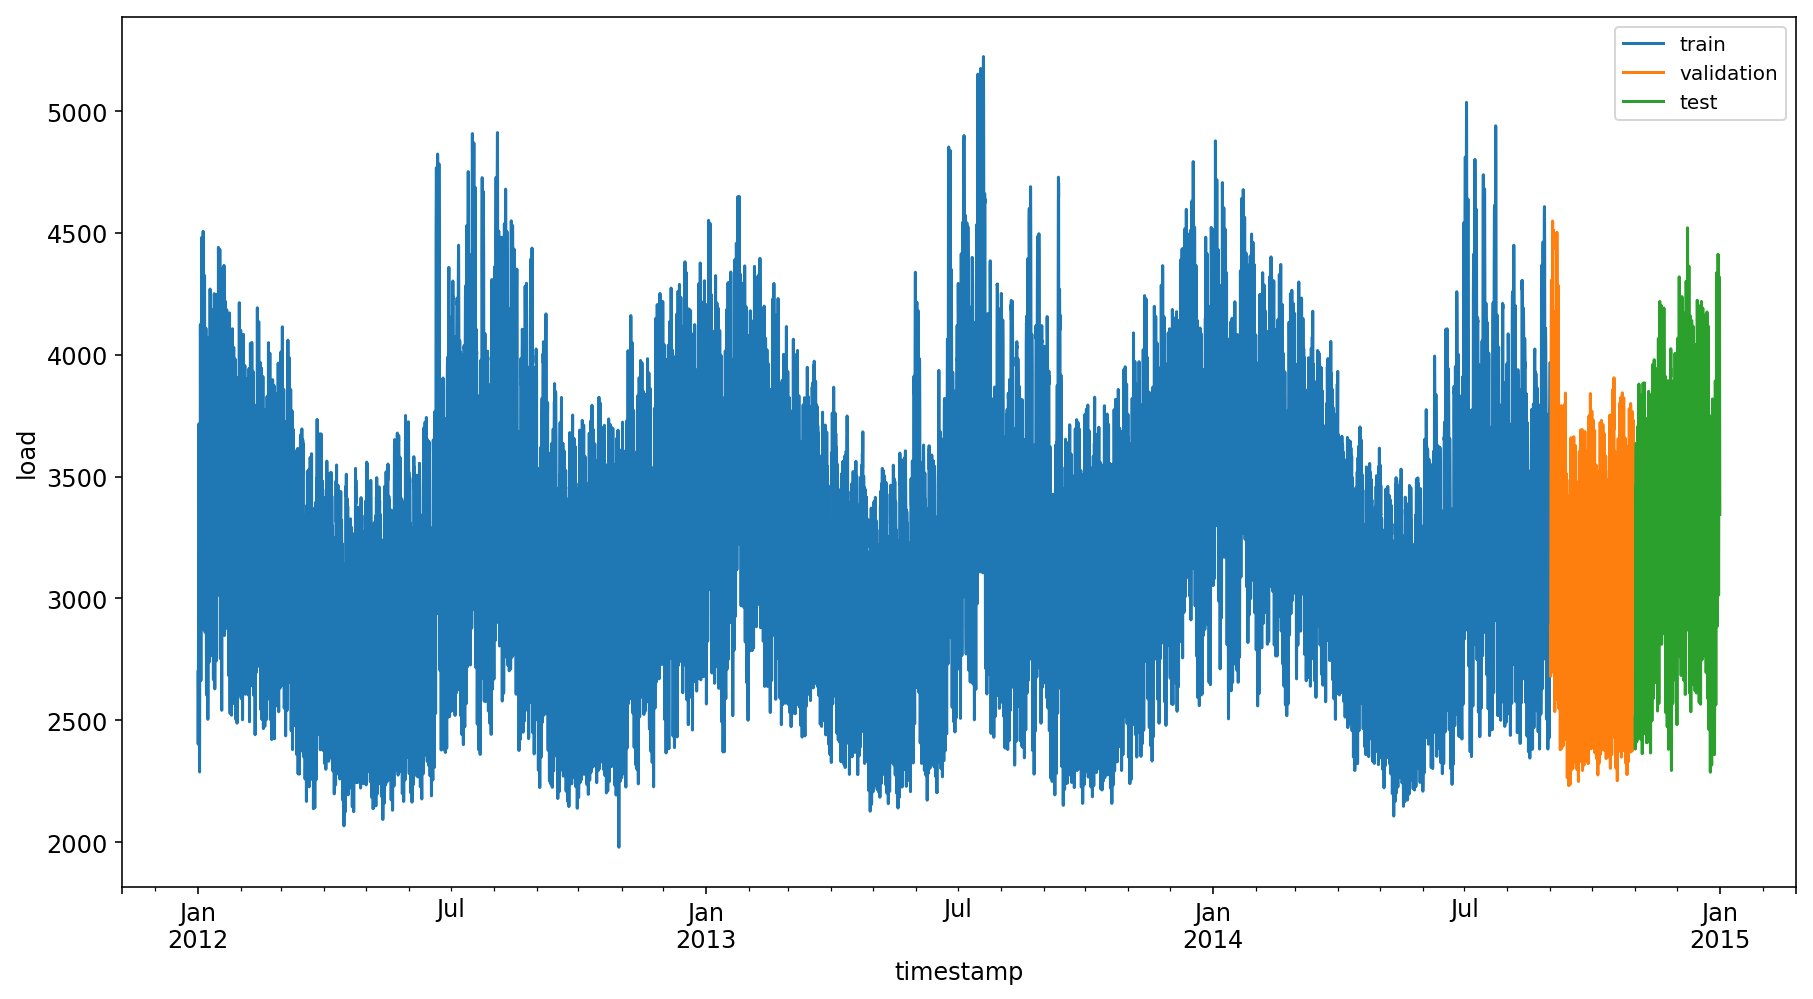

In [5]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'train'}) \
    .join(energy[(energy.index >=valid_start_dt) & (energy.index < test_start_dt)][['load']] \
          .rename(columns={'load':'validation'}), how='outer') \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

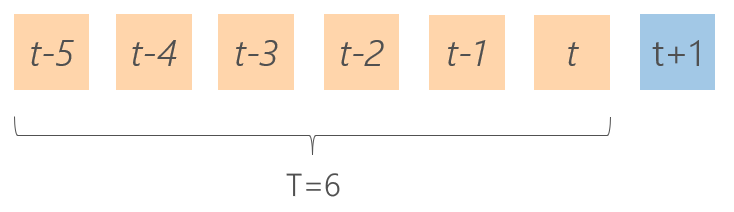

In [6]:
Image('./images/one_step_forecast.png')

In [7]:
T = 6
HORIZON = 1

#### Data preparation - training set

In [8]:
# 1. Get the train data from the correct data range
train = energy.copy()[energy.index < valid_start_dt][['load']]

# 2. Scale data to be in range (0, 1). 
#   This transformation should be calibrated on the training set only. 
#   This is to prevent information from the validation or test sets 
#   leaking into the training data.
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)

# 3. Shift the dataframe to create the input samples.
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    train_shifted[str(T-t)] = train_shifted['load'].shift(T-t, freq='H')
y_col = 'y_t+1'
X_cols = ['load_t-5',
             'load_t-4',
             'load_t-3',
             'load_t-2',
             'load_t-1',
             'load_t']
train_shifted.columns = ['load_original']+[y_col]+X_cols

# 4.Discard any samples with missing values
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 09:00:00,0.35,0.37,0.13,0.15,0.18,0.23,0.29,0.35


Now convert the target and input features into numpy arrays. X needs to be in the **shape (samples, time steps, features)**. Here we have 23370 samples, 6 time steps and 1 feature (load).

In [9]:
# 5.Transform this Pandas dataframe into a numpy array
y_train = train_shifted[y_col].as_matrix()
X_train = train_shifted[X_cols].as_matrix()

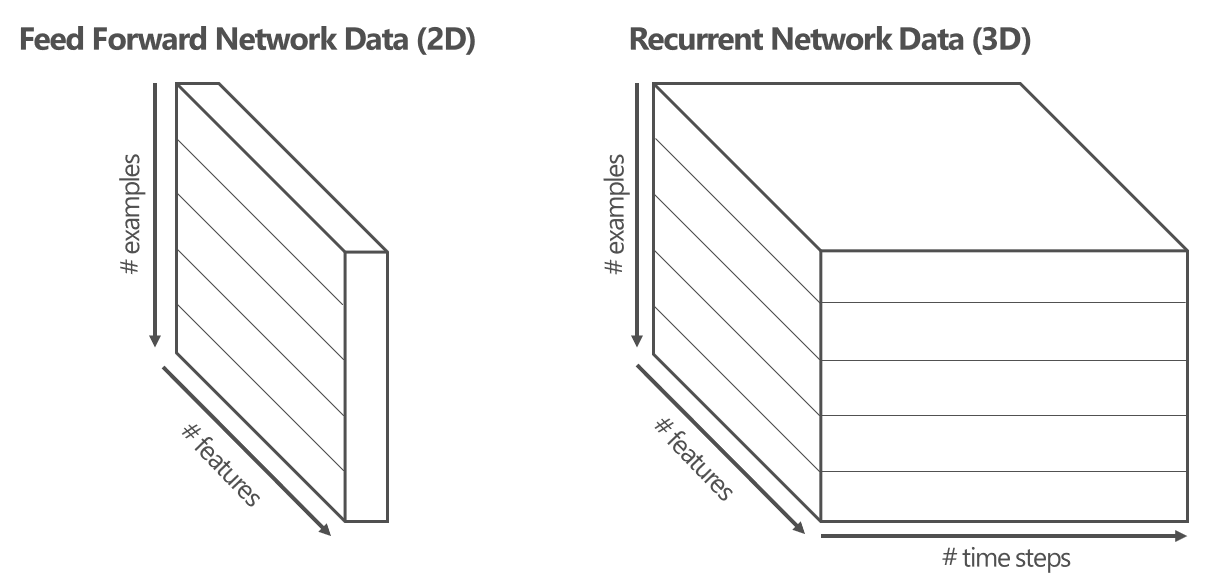

In [10]:
Image('./images/rnn_data_prep.png')

In [10]:
# This is an important step to reshape the X into 3 dimension array
X_train = X_train.reshape(X_train.shape[0], T, 1)

We now have a vector for target variable of shape:

In [11]:
y_train.shape

(23370,)

The target varaible for the first 3 samples looks like:

In [12]:
y_train[:3]

array([0.18, 0.23, 0.29])

The tensor for the input features now has the shape:

In [13]:
X_train.shape

(23370, 6, 1)

And the first 3 samples looks like:

In [14]:
X_train[:3]

array([[[0.22],
        [0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15]],

       [[0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18]],

       [[0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18],
        [0.23]]])

We can sense check this against the first 3 records of the original dataframe:

In [15]:
train_shifted.head(3)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23


#### Data preparation - validation set

Now we follow a similar process for the validation set. We keep *T* hours from the training set in order to construct initial features.

In [16]:
# 1. Get the validation data from the correct data range
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load']]

# 2. Scale the series using the transformer fitted on the training set:
valid['load'] = scaler.transform(valid)

# 3. Shift the dataframe to create the input samples
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    valid_shifted['load_t-'+str(T-t)] = valid_shifted['load'].shift(T-t, freq='H')
    
# 4.Discard any samples with missing values
valid_shifted = valid_shifted.dropna(how='any')
valid_shifted.head(3)

,load,y+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
2014-09-01 00:00:00,0.28,0.24,0.61,0.58,0.51,0.43,0.34,0.28
2014-09-01 01:00:00,0.24,0.22,0.58,0.51,0.43,0.34,0.28,0.24
2014-09-01 02:00:00,0.22,0.22,0.51,0.43,0.34,0.28,0.24,0.22


In [17]:
# 5.Transform this Pandas dataframe into a numpy array
y_valid = valid_shifted['y+1'].as_matrix()
X_valid = valid_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].as_matrix()
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

Prepare validation inputs in the same way as the training set:

In [18]:
y_valid.shape

(1463,)

In [19]:
y_valid[:3]

array([0.24, 0.22, 0.22])

In [20]:
X_valid.shape

(1463, 6, 1)

In [21]:
X_valid[:3]

array([[[0.61],
        [0.58],
        [0.51],
        [0.43],
        [0.34],
        [0.28]],

       [[0.58],
        [0.51],
        [0.43],
        [0.34],
        [0.28],
        [0.24]],

       [[0.51],
        [0.43],
        [0.34],
        [0.28],
        [0.24],
        [0.22]]])

## Implement the RNN

We will implement a simple RNN forecasting model with the following structure:

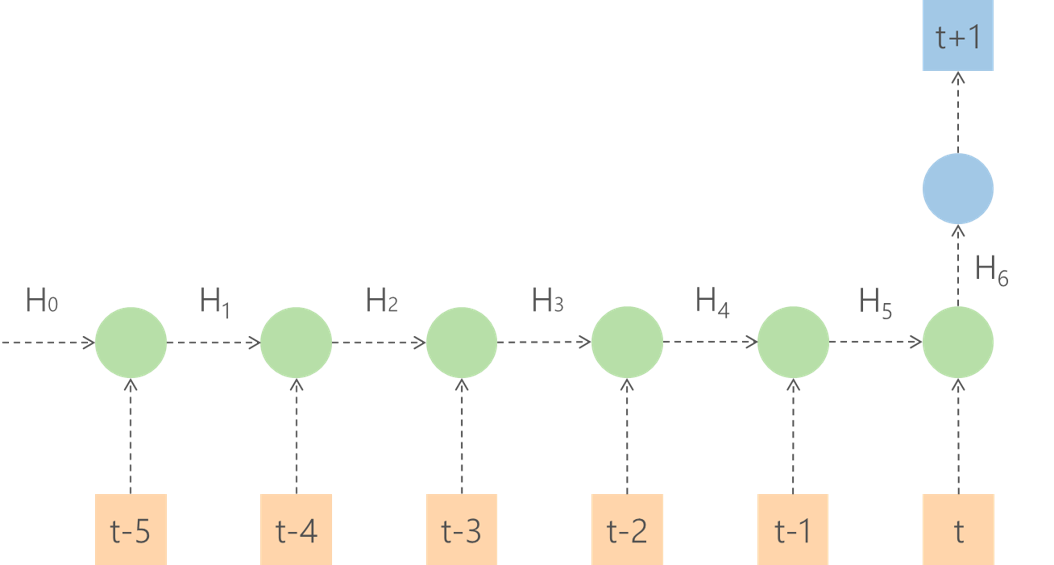

In [22]:
Image('./images/one_step_univariate.png')

In [23]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [24]:
LATENT_DIM = 5 # number of units in the RNN layer
BATCH_SIZE = 32 # number of samples per mini-batch
EPOCHS = 10 # maximum number of times the training algorithm will cycle through all samples

In [25]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))

Use mean squared error as the loss function. The Keras documentation recommends the optimizer RMSprop for RNNs.

In [26]:
model.compile(optimizer='RMSprop', loss='mse')

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 5)                 105       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 111
Trainable params: 111
Non-trainable params: 0
_________________________________________________________________


Specify the early stopping criteria. We **monitor** the validation loss (in this case the mean squared error) on the validation set after each training epoch. If the validation loss has not improved by **min_delta** after **patience** epochs, we stop the training.

In [28]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [29]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=1)

Train on 23370 samples, validate on 1463 samples
Epoch 1/10
23370/23370 [==============================] - 3s 119us/step - loss: 0.0087 - val_loss: 0.0018
Epoch 2/10
23370/23370 [==============================] - 2s 95us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 3/10
23370/23370 [==============================] - 2s 90us/step - loss: 9.2189e-04 - val_loss: 7.0295e-04
Epoch 4/10
23370/23370 [==============================] - 2s 98us/step - loss: 7.2670e-04 - val_loss: 6.1398e-04
Epoch 5/10
23370/23370 [==============================] - 2s 91us/step - loss: 6.3658e-04 - val_loss: 6.4337e-04
Epoch 6/10
23370/23370 [==============================] - 2s 95us/step - loss: 5.9180e-04 - val_loss: 9.4040e-04
Epoch 7/10
23370/23370 [==============================] - 3s 118us/step - loss: 5.7113e-04 - val_loss: 5.0341e-04
Epoch 8/10
23370/23370 [==============================] - 2s 104us/step - loss: 5.6449e-04 - val_loss: 5.4319e-04
Epoch 9/10
23370/23370 [==============================] - 3s

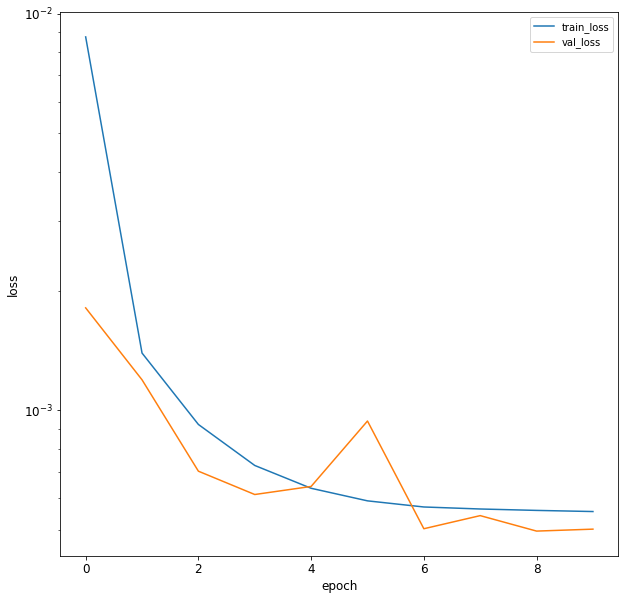

In [30]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

## Evaluate the model

Data preperation - test set

In [31]:
# 1. Get the test data from the correct data range
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load']]

# 2. Scale the data
test['load'] = scaler.transform(test)

# 3. Shift the dataframe to create the input samples
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    test_shifted['load_t-'+str(T-t)] = test_shifted['load'].shift(T-t, freq='H')

# 4.Discard any samples with missing values
test_shifted = test_shifted.dropna(how='any')

# 5.Transform this Pandas dataframe into a numpy array
y_test = test_shifted['y_t+1'].as_matrix()
X_test = test_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].as_matrix()
X_test = X_test.reshape(X_test.shape[0], T, 1)


In [32]:
y_test.shape

(1458,)

In [33]:
X_test.shape

(1458, 6, 1)

Make predictions on test set

In [34]:
predictions = model.predict(X_test)
predictions

array([[0.21],
       [0.29],
       [0.37],
       ...,
       [0.52],
       [0.45],
       [0.42]], dtype=float32)

Compare predictions to actual load

In [35]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,661.89","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,926.59","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,192.69","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,324.49","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,451.99","3,436.00"


Compute the mean absolute percentage error over all predictions

In [36]:
# %load -s mape common/utils.py
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()

In [37]:
mape(eval_df['prediction'], eval_df['actual'])

0.01624810070962179

Plot the predictions vs the actuals for the first week of the test set

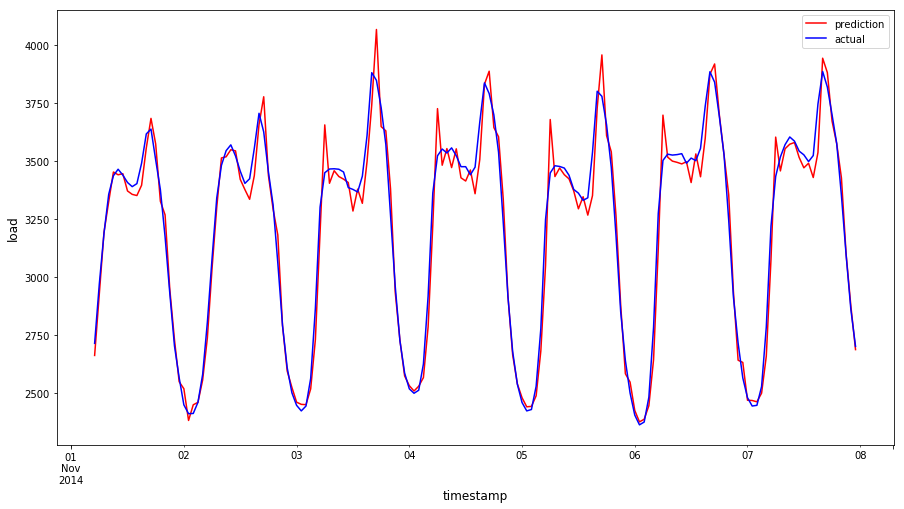

In [38]:
eval_df[eval_df.timestamp<'2014-11-08'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()